<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S7_2_1_Cifar10_with_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar10 with ResNet 

Nous avons vu comment classer des images du dataset Cifar10 avec une structure de CNN qu'on a créé à la main. Nous allons voir comment on peut améliorer nos résultats avec un MobileNet 

* Importez :
  * Tensorflow 2.0
  * Numpy 
  * Matplotlib.pyplot 

In [0]:
#!pip install tensorflow-gpu==2.0.0beta1
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

* En utilisant [`tf.keras.datasets`](https://www.tensorflow.org/api_docs/python/tf/keras/datasets) importez cifar10 et stockez les données dans `X_train, y_train, X_test, y_test`

In [3]:
data = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
 X_train, y_train = data[0][0], data[0][1]
 X_test, y_test = data[1][0], data[1][1]

* Visualisez une image aléatoire de votre dataset 

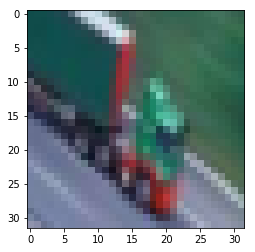

In [15]:
plt.imshow(X_train[50])

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[5]')

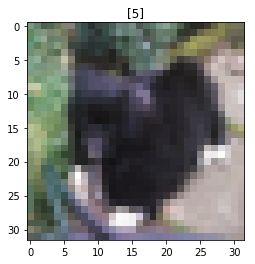

* Visualisez une image aléatoire de chacun de vos labels dans votre dataset 

In [24]:
y_train[0]

array([6], dtype=uint8)

index = 0


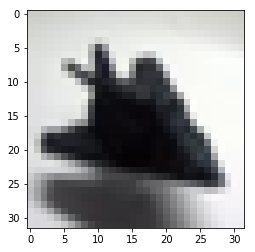

index = 1


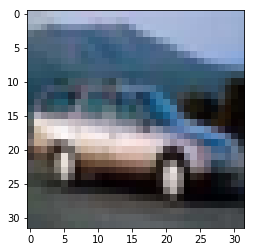

index = 2


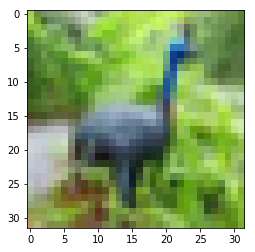

index = 3


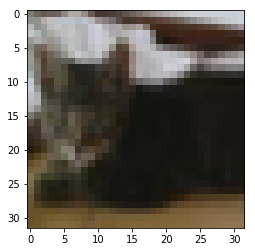

index = 4


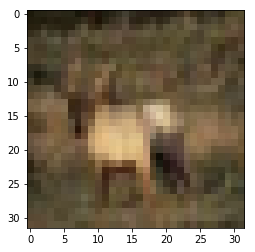

index = 5


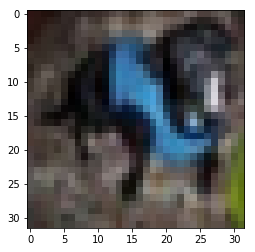

index = 6


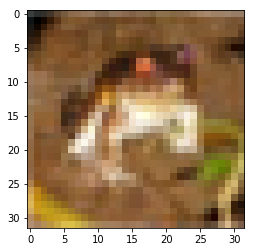

index = 7


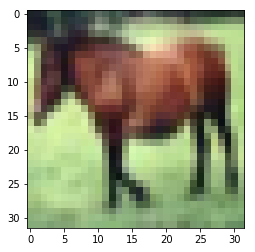

index = 8


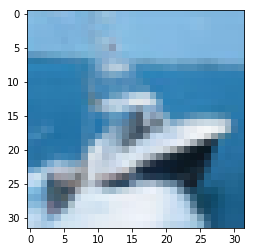

In [32]:
for i in range(0,9):
  result = np.where(y_train == i)
  print("index = {}".format(i))
  plt.imshow(X_train[result[0][0]])
  plt.show()

index for each image :[0 1 2 3 4 5 6 7 8 9]


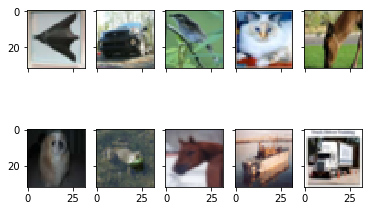

* Nous allons procéder à une partie de _data augmentation_. En utilisant [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), appliquez les choses suivantes : 
  * Flip horizontal aléatoire 
  * Shear_range à 0.2
  * Zoom_range à 0.2
  * Rescale à 1/255.0

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale= 1/255.0)

In [0]:
datagen.fit(X_train)

* Regardez que vous ayez bien fitté vos images sur votre `X_train` et tentez de regarder la _shape_ d'un set de données 

(1, 32, 32, 3)

* Visualisez une image aléatoire après avoir fait votre _data augmentation_ pour vérifier que tout s'est bien passé 

In [0]:
'''from keras.models import Sequential
model = tf.keras.Sequential()
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=int(len(X_train) / 32), epochs=3)


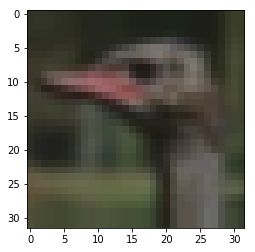

In [47]:
val_generator = datagen.flow(X_train, y_train)
x,y = val_generator.next()

image = x[0]
plt.imshow(image)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[[2]]')

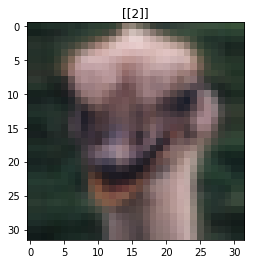

* Nous allons maintenant créer notre modèle. Pour cela, nous allons importer `ResNet`. Pour ce faire : 
  * Utilisez `tf.keras.applications.Resnet50`
  * N'oubliez pas de pas inclure la dernière couche 
  * Ajoutez y les poids de "imagenet"

In [58]:
base_model = tf.keras.applications.ResNet50(input_shape=(32,32,3), 
                                               include_top=False,
                                               weights = "imagenet"
                                               )

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


* Regardez les couches de votre modèle en utilisant `model.summary()`

In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

* Gelez toutes les couches de votre modèle 

In [0]:
base_model.trainable = False

* Ajoutez la dernière couche de votre modèle pour l'adapter à votre dataset 

In [0]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(y_train), activation="softmax")
])

* Créez une _Learning Rate Schedule_. Vous pouvez choisir de le faire avec [_ExponentialDecay_](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) ou [d'autres méthodes](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules)

In [0]:
# Créons un learning rate schedule pour décroitre le learning rate à mesure que nous entrainons le modèle 
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

* Créez un compileur dans lequel vous choisirez : 
  * Votre optimiseur 
  * Votre loss 
  * Vos métrics 

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

* Faites tourner votre modèle sur 5 epochs 

In [63]:
model.fit(X_train, y_train, epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples
Epoch 1/5
50000/50000 [==============================] - 142s 3ms/sample - loss: 1.7913 - sparse_categorical_accuracy: 0.4324
Epoch 2/5
50000/50000 [==============================] - 136s 3ms/sample - loss: 1.6712 - sparse_categorical_accuracy: 0.4602
Epoch 3/5
50000/50000 [==============================] - 136s 3ms/sample - loss: 1.6418 - sparse_categorical_accuracy: 0.4704
Epoch 4/5
50000/50000 [==============================] - 137s 3ms/sample - loss: 1.6222 - sparse_categorical_accuracy: 0.4716
Epoch 5/5
50000/50000 [==============================] - 136s 3ms/sample - loss: 1.6011 - sparse_categorical_accuracy: 0.4753


W0704 17:51:06.273052 139681010259840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
3125/3125 [==============================] - 145s 46ms/step - loss: 1.9355 - sparse_categorical_accuracy: 0.3690
Epoch 2/5
3125/3125 [==============================] - 139s 44ms/step - loss: 1.7308 - sparse_categorical_accuracy: 0.4217
Epoch 3/5
3125/3125 [==============================] - 145s 46ms/step - loss: 1.6963 - sparse_categorical_accuracy: 0.4277
Epoch 4/5
3125/3125 [==============================] - 144s 46ms/step - loss: 1.6755 - sparse_categorical_accuracy: 0.4364
Epoch 5/5
3125/3125 [==============================] - 143s 46ms/step - loss: 1.6746 - sparse_categorical_accuracy: 0.4368


* Evaluez votre modèle grâce à [`model.evaluate_generator`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate_generator)

In [67]:
model.evaluate_generator(val_generator)

[6.4916902790447875, 0.1]

10000/10000 [==============================] - 12s 1ms/sample - loss: 4.1367 - sparse_categorical_accuracy: 0.2127


[4.136723045730591, 0.2127]

* Regardez le nombre de layers que vous avez dans votre modèle 

32

175

* Notre modèle pourrait donner des meilleurs scores si nous débloquions quelques couches. Débloquez les 150 dernières couches.

In [0]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

* Tentez d'entrainer votre modèle à nouveau. Cette fois cependant : 
  * Ajoutez l'argument *validation_data = (X_test, y_test)*  
  * Profitez en pour enregistrer votre entrainement dans une variable _history_
  
* Que pouvez vous conclure sur votre modèle ?

In [93]:
#il faut utiliser model.fit_generator pour utiliser le generator responsable de la Data augmentation
model.fit_generator(val_generator, epochs=5,  validation_data = (X_test, y_test))

Epoch 1/5
1563/1563 [==============================] - 434s 278ms/step - loss: 0.9788 - sparse_categorical_accuracy: 0.6697 - val_loss: 14.5155 - val_sparse_categorical_accuracy: 0.0994
Epoch 2/5
1563/1563 [==============================] - 435s 278ms/step - loss: 0.8310 - sparse_categorical_accuracy: 0.7167 - val_loss: 14.5122 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 433s 277ms/step - loss: 0.7954 - sparse_categorical_accuracy: 0.7339 - val_loss: 14.5090 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 432s 276ms/step - loss: 0.7557 - sparse_categorical_accuracy: 0.7459 - val_loss: 14.5090 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 447s 286ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.7716 - val_loss: 14.5074 - val_sparse_categorical_accuracy: 0.1001


Epoch 1/5
3125/3125 [==============================] - 356s 114ms/step - loss: 2.1451 - sparse_categorical_accuracy: 0.3300 - val_loss: 2.7351 - val_sparse_categorical_accuracy: 0.2212
Epoch 2/5
3125/3125 [==============================] - 321s 103ms/step - loss: 1.6376 - sparse_categorical_accuracy: 0.4215 - val_loss: 2.3547 - val_sparse_categorical_accuracy: 0.2617
Epoch 3/5
3125/3125 [==============================] - 320s 102ms/step - loss: 1.5118 - sparse_categorical_accuracy: 0.4670 - val_loss: 2.4551 - val_sparse_categorical_accuracy: 0.2587
Epoch 4/5
3125/3125 [==============================] - 319s 102ms/step - loss: 1.4229 - sparse_categorical_accuracy: 0.4943 - val_loss: 2.3462 - val_sparse_categorical_accuracy: 0.2991
Epoch 5/5
3125/3125 [==============================] - 318s 102ms/step - loss: 1.3618 - sparse_categorical_accuracy: 0.5167 - val_loss: 2.1834 - val_sparse_categorical_accuracy: 0.3148


* Regardez ce qu'il y a dans `history.history`

In [94]:
model.history.history

{'loss': [0.9786243128967285,
  0.8311415886878968,
  0.7954506213951111,
  0.7555861149978638,
  0.6773666465091706],
 'sparse_categorical_accuracy': [0.66966, 0.71666, 0.73394, 0.74586, 0.77162],
 'val_loss': [14.515466089827566,
  14.512240784617658,
  14.509022404972356,
  14.509022404972356,
  14.507413169446464],
 'val_sparse_categorical_accuracy': [0.0994, 0.1, 0.1, 0.1, 0.1001]}

{'loss': [2.1451443428802492,
  1.637629423828125,
  1.5118215949630738,
  1.4228600004386902,
  1.3617993776702881],
 'sparse_categorical_accuracy': [0.32998, 0.4215, 0.46702, 0.49426, 0.5167],
 'val_loss': [2.7350883081436157,
  2.3547028923034667,
  2.4550603506088255,
  2.3461508337020875,
  2.183382035636902],
 'val_sparse_categorical_accuracy': [0.2212, 0.2617, 0.2587, 0.2991, 0.3148]}

* Regardez maintenant un graphique de l'évolution de votre *loss*  à mesure que les epochs avancent  

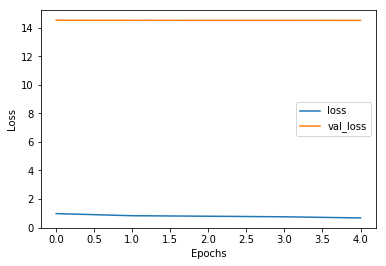

In [95]:
loss = model.history.history.get('loss')
val_loss = model.history.history.get('val_loss')
plt.plot(loss, label = "loss")
plt.plot(val_loss, label = "val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

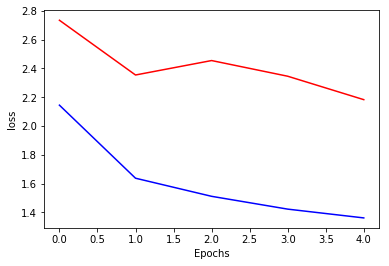

* Faites de même avec votre Accuracy 

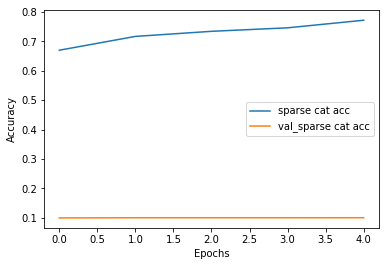

In [96]:
plt.plot(model.history.history.get('sparse_categorical_accuracy'), label = "sparse cat acc")
plt.plot(model.history.history.get('val_sparse_categorical_accuracy'), label = "val_sparse cat acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

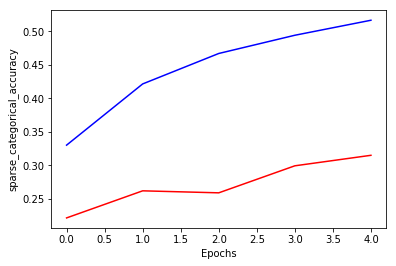